# Campo de Pruebas con H2O



## Conexion y carga

Conexion con $H_2O$, con crate, descarga de datos, procesamiento y listo para procesar con ML

In [1]:
import h2o
from crate import client
import pandas as pd
from h2o.automl import H2OAutoML

import matplotlib.pyplot as plt
from scipy import stats


#########################
# Inicializar Servicios
#########################

#HOST_CRATE="http://atd-z32togop.cloud.uco.es:4200"

HOST_CRATE="http://localhost:4200"
# Realizamos la conexion a nuestro puerto conectado con el servidor mediante el tunel SSH
h2o.init(url="http://localhost:55554")

# Conectamos con CrateDB
connection = client.connect(HOST_CRATE, username="crate")
cursor = connection.cursor()

# Consultamos las tablas existentes en CrateDB
cursor.execute("SHOW TABLES")
tables = cursor.fetchall()
print("Tablas disponibles:", tables)


Checking whether there is an H2O instance running at http://localhost:55554..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "17.0.13" 2024-10-15; OpenJDK Runtime Environment (build 17.0.13+11-Ubuntu-2ubuntu122.04); OpenJDK 64-Bit Server VM (build 17.0.13+11-Ubuntu-2ubuntu122.04, mixed mode, sharing)
  Starting server from /home/p3j0t4/.local/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpin4ljc5c
  JVM stdout: /tmp/tmpin4ljc5c/h2o_p3j0t4_started_from_python.out
  JVM stderr: /tmp/tmpin4ljc5c/h2o_p3j0t4_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Africa/Ceuta
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,3 months and 1 day
H2O_cluster_name:,H2O_from_python_p3j0t4_vkm1sb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.830 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Removed server http://localhost:4200 from active pool


ConnectionError: No more Servers available, exception from last server: HTTPConnectionPool(host='localhost', port=4200): Max retries exceeded with url: /_sql?types=true (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x767d2d719c60>: Failed to establish a new connection: [Errno 111] Connection refused'))

H2O session _sid_bf79 closed.


/tmp/ipykernel_8018/2900054706.py:1: H2ODeprecationWarning: Deprecated, use ``h2o.cluster().shutdown()``.
  h2o.shutdown()


In [2]:
import pandas as pd

def query_to_dataframe(crate_host, query, username="crate"):
    """
    Ejecuta una consulta en CrateDB y devuelve los resultados como un DataFrame de pandas.

    :param crate_host: Dirección del servidor CrateDB (por ejemplo, "http://localhost:4200/")
    :param query: Consulta SQL a ejecutar
    :param username: Usuario para la conexión (por defecto "crate")
    :return: pandas DataFrame con los resultados de la consulta
    """
    try:
        # Conexión a CrateDB
        connection = client.connect(crate_host, username=username)
        cursor = connection.cursor()

        # Ejecutar la consulta
        cursor.execute(query)

        # Obtener las columnas de la consulta
        columns = [col[0] for col in cursor.description]

        # Obtener los resultados de la consulta
        data = cursor.fetchall()

        # Convertir los resultados a un DataFrame de pandas
        df = pd.DataFrame(data, columns=columns)

        # Cerrar la conexión
        cursor.close()
        connection.close()

        return df

    except Exception as e:
        print("Error en la consulta:", e)
        return None


In [3]:
##################
# Obtener datos de crate
##################

query= """ 
SELECT entity_id, time_index, no2, so2, o3, pm10, pm25
FROM "mtatdfiware"."etestacion_meteo"
WHERE entity_id LIKE 'COCOR_LEPANTO' """ # Esta consulta es la misma que hacemos en el portal de crate para buscar cierta tabla, en este ejemplo vamos a trabajar con los datos de COCOR_LEPANTO
cursor.execute(query)

df=query_to_dataframe(HOST_CRATE, query,"crate")

#Eliminamos datos faltantes
df.dropna(inplace=True)

#Eliminamos columna entity_id
df.drop(columns=["entity_id"],inplace=True)

#Convertimos la columna time_index como indice del df
df["time_index"]=pd.to_datetime(df["time_index"],unit="ms")
#ordenamos de mas antiguo a mas reciente
df.sort_values("time_index", inplace=True)
df.set_index("time_index", inplace=True)

print(df.head(),"\n")
print("Dimension df:", df.shape,"\n")
print("Tipos de datos de las columnas:\n",df.dtypes)
print("\nValores nulos por columna:\n",df.isnull().sum())

                      no2  so2      o3     pm10    pm25
time_index                                             
2022-10-04 01:00:00  13.0  3.0  59.750   95.940  31.579
2022-10-04 02:00:00  10.0  3.0  55.500   98.685  32.330
2022-10-04 03:00:00  10.0  3.0  50.500  100.800  32.860
2022-10-04 05:00:00  11.0  3.0  41.375  104.400  33.390
2022-10-04 06:00:00  14.0  2.0  41.000  106.065  33.743 

Dimension df: (11286, 5) 

Tipos de datos de las columnas:
 no2     float64
so2     float64
o3      float64
pm10    float64
pm25    float64
dtype: object

Valores nulos por columna:
 no2     0
so2     0
o3      0
pm10    0
pm25    0
dtype: int64


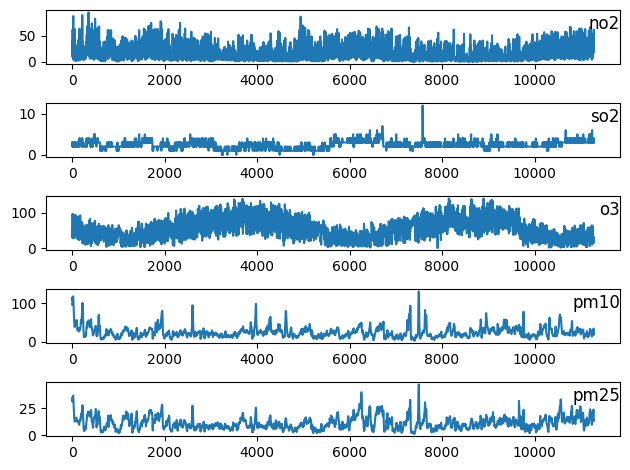

In [59]:
#############################
# Visualización de los datos
#############################


import matplotlib.pyplot as plt

# groups' es una lista de índices de columnas que deseas graficar
groups = [0, 1, 2, 3, 4]  # Ajusta esto según tus columnas
values = df.values  # Asegúrate de que 'df' sea tu DataFrame

plt.figure()
for i, group in enumerate(groups, start=1):
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(df.columns[group], y=0.5, loc='right')

plt.tight_layout()
plt.show()

## Con Lagg

In [7]:
import pandas as pd

def lagged_df(df,var_objetivo, num_lags=12, delay=12):
    """
    Procesa el DataFrame agregando columnas de retardos (lags) y medias móviles.

    Args:
    df (pd.DataFrame): DataFrame original. ESTRUCTURA: [index=datetime, columns=features] solo valores numericos.
    num_lags (int): Número de retardos (lags) y longitudes de ventana para la agregación de la media.
    delay (int): Predice el objetivo un paso adelante.

    Returns:
    pd.DataFrame: DataFrame procesado con columnas de retardos y medias móviles.
    """
    df2 = df.copy()  # Crea una copia del DataFrame original para no modificar el original

    # Itera sobre cada columna del DataFrame
    for column in df2:
        for lag in range(1, num_lags + 1):
            # Crea columnas de retardos (lags) para cada columna
            df2[column + '_lag' + str(lag)] = df2[column].shift(lag * -1 - (delay - 1))
            
            # Si la columna no es 'entity_id', crea columnas de medias móviles
            if column != 'entity_id':
                df2[column + '_avg_window_length' + str(lag + 1)] = df2[column].shift(-1 - (delay - 1)).rolling(window=lag + 1, center=False).mean().shift(1 - (lag + 1))

    # Elimina las filas con valores NaN resultantes de los desplazamientos
    df2.dropna(inplace=True)

    # Crea una máscara para seleccionar columnas que contienen la variable objetivo, 'lag' o 'window'
    mask = (df2.columns.str.contains(var_objetivo) | df2.columns.str.contains('lag') | df2.columns.str.contains('window'))

    # Filtra el DataFrame para mantener solo las columnas seleccionadas por la máscara
    df_processed = df2[df2.columns[mask]]

    return df_processed


In [9]:
###############
# Distribución Variable Objetivo
################

var_objetivo = 'no2'  # Variable objetivo
df_processed = lagged_df(df, var_objetivo, num_lags=12, delay=12)
mask = df_processed.columns.str.contains(var_objetivo)
df_objetivo_lag=df_processed[df_processed.columns[mask]]
#df_objetivo_lag.head(10)
df_processed.head(10)

/tmp/ipykernel_9631/1624188804.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[column + '_avg_window_length' + str(lag + 1)] = df2[column].shift(-1 - (delay - 1)).rolling(window=lag + 1, center=False).mean().shift(1 - (lag + 1))
/tmp/ipykernel_9631/1624188804.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[column + '_lag' + str(lag)] = df2[column].shift(lag * -1 - (delay - 1))
/tmp/ipykernel_9631/1624188804.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.

,no2,no2_lag1,no2_avg_window_length2,no2_lag2,no2_avg_window_length3,no2_lag3,no2_avg_window_length4,no2_lag4,no2_avg_window_length5,no2_lag5,...,pm25_lag8,pm25_avg_window_length9,pm25_lag9,pm25_avg_window_length10,pm25_lag10,pm25_avg_window_length11,pm25_lag11,pm25_avg_window_length12,pm25_lag12,pm25_avg_window_length13
time_index,,,,,,,,,,,,,,,,,,,,,
2022-10-04 01:00:00,13.0,15.0,15.0,15.0,15.666667,17.0,21.25,38.0,23.6,33.0,...,36.349,35.156667,36.835,35.3201,36.791,35.437727,36.614,35.491583,36.084,35.482846
2022-10-04 02:00:00,10.0,15.0,16.0,17.0,23.333333,38.0,25.75,33.0,27.2,33.0,...,36.835,35.554222,36.791,35.6602,36.614,35.698727,36.084,35.672000,35.378,35.571231
2022-10-04 03:00:00,10.0,17.0,27.5,38.0,29.333333,33.0,30.25,33.0,28.4,21.0,...,36.791,35.868222,36.614,35.8898,36.084,35.843273,35.378,35.719833,34.362,35.530462
2022-10-04 05:00:00,11.0,38.0,35.5,33.0,34.666667,33.0,31.25,21.0,27.6,13.0,...,36.614,36.084111,36.084,36.0135,35.378,35.863364,34.362,35.646250,33.258,35.381000
2022-10-04 06:00:00,14.0,33.0,33.0,33.0,29.000000,21.0,25.00,13.0,21.4,7.0,...,36.084,36.128333,35.378,35.9517,34.362,35.706818,33.258,35.414417,32.198,35.092231
2022-10-04 07:00:00,25.0,33.0,27.0,21.0,22.333333,13.0,18.50,7.0,16.0,6.0,...,35.378,36.030222,34.362,35.7530,33.258,35.429818,32.198,35.079500,31.226,34.718538
2022-10-04 09:00:00,41.0,21.0,17.0,13.0,13.666667,7.0,11.75,6.0,11.2,9.0,...,34.362,35.750556,33.258,35.3953,32.198,35.016273,31.226,34.630500,30.387,34.246308
2022-10-04 14:00:00,12.0,13.0,10.0,7.0,8.666667,6.0,8.75,9.0,24.6,88.0,...,33.258,35.318778,32.198,34.9095,31.226,34.498364,30.387,34.093167,29.636,33.519231
2022-10-04 20:00:00,27.0,7.0,6.5,6.0,7.333333,9.0,27.50,88.0,24.2,11.0,...,32.198,34.749556,31.226,34.3133,30.387,33.888091,29.636,33.283417,26.632,32.608692


In [65]:
############################
# Train_test_split
###################

#Tamaño del test
train_size=len(df_processed)*0.8
df_train=df_processed[:int(train_size)]
df_test=df_processed[int(train_size):]

print("Dimension train:", df_train.shape)
print("Dimension test:", df_test.shape)

Dimension train: (9025, 31)
Dimension test: (2257, 31)


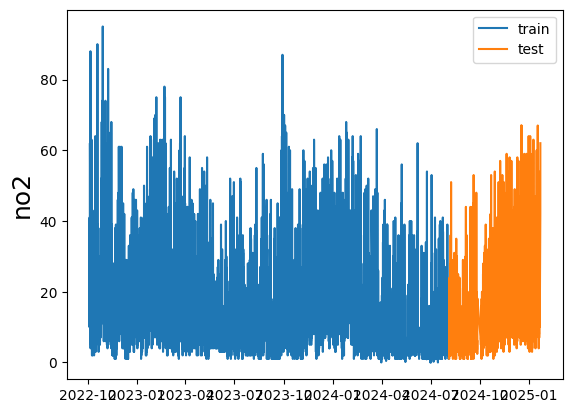

In [66]:
#################3
# Grafico de la variable objetivo
##################

plt.plot(df_train.index,df_train[var_objetivo])
plt.plot(df_test.index,df_test[var_objetivo])
plt.ylabel(var_objetivo,fontsize=18)
plt.legend(['train','test'])
plt.show()

In [67]:
##################
# Pasamos a dataframe de H2O
##################


hf_train = h2o.H2OFrame(df_train, destination_frame="COCOR_LEPANTO_lagged_train")
X=hf_train.columns #elegimos las variables independientes de nuestro modelo 
X.remove(var_objetivo)
hf_test = h2o.H2OFrame(df_test, destination_frame="COCOR_LEPANTO_lagged_test")  


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


### autoML

In [68]:
from h2o.automl import H2OAutoML

#Configuramos el modelo
aml = H2OAutoML(max_runtime_secs = 600,
                seed = 42,stopping_metric="RMSE",sort_metric="RMSE", keep_cross_validation_models=True,project_name="COCOR_LEPANTO_lagged_no2",nfolds=-1)
#Lo entrenamos
aml.train(x = X, 
          y = var_objetivo,
          training_frame = hf_train,
          leaderboard_frame = hf_test)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),11/12
# GBM base models (used / total),4/5
# XGBoost base models (used / total),3/3
# DeepLearning base models (used / total),1/1
# DRF base models (used / total),2/2
# GLM base models (used / total),1/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5


In [70]:
##################
# Tabla de Modelos comparados
##################

lb=aml.leaderboard
lb

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
StackedEnsemble_AllModels_2_AutoML_1_20250123_131148,7.81075,61.0078,5.34037,0.451547,61.0078
StackedEnsemble_AllModels_3_AutoML_1_20250123_131148,7.83469,61.3824,5.40283,0.455906,61.3824
StackedEnsemble_AllModels_1_AutoML_1_20250123_131148,7.84241,61.5034,5.43833,0.456113,61.5034
StackedEnsemble_BestOfFamily_4_AutoML_1_20250123_131148,7.84522,61.5475,5.38554,0.454256,61.5475
StackedEnsemble_BestOfFamily_3_AutoML_1_20250123_131148,7.84756,61.5841,5.36561,0.452895,61.5841
GBM_grid_1_AutoML_1_20250123_131148_model_14,7.88235,62.1314,5.44199,0.46093,62.1314
StackedEnsemble_BestOfFamily_1_AutoML_1_20250123_131148,7.88285,62.1393,5.47186,0.459031,62.1393
StackedEnsemble_BestOfFamily_2_AutoML_1_20250123_131148,7.8835,62.1496,5.45719,0.457596,62.1496
GBM_1_AutoML_1_20250123_131148,7.9017,62.4368,5.47643,0.460828,62.4368
GBM_2_AutoML_1_20250123_131148,7.91632,62.6681,5.49168,0.463554,62.6681


In [76]:
##################
# Predicciones 
##################

#realizamos las predicciones
pred=aml.leader.predict(hf_test)


#Creamos una tabla comparativa y_true vs y_pred
df_result=pd.DataFrame()
df_result["y_true"]=df_test[var_objetivo].reset_index(drop=True)
df_result["y_pred"]=h2o.as_list(pred,use_pandas=True)
df_result.head()


stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/home/p3j0t4/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


,y_true,y_pred
0,3.0,3.950731
1,2.0,2.754816
2,1.0,2.298993
3,1.0,2.626109
4,2.0,5.682001


In [80]:
#Sacamos metricas

slope, intercept, r_value, p_value, std_err = stats.linregress(x=df_result['y_pred'],y=df_result['y_true'])
print('R2 = ',r_value*r_value)

R2 =  0.635462598680407


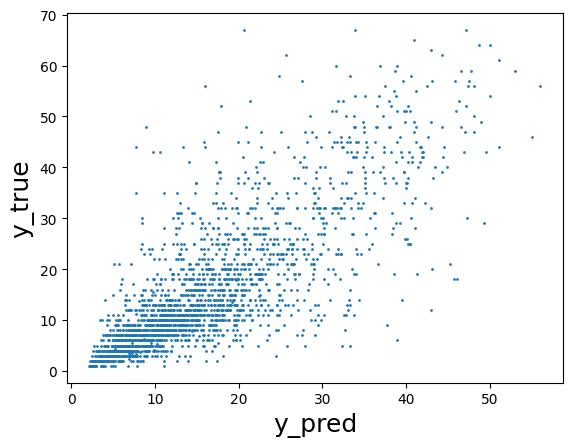

In [81]:
plt.scatter(x=df_result['y_pred'],y=df_result['y_true'],s=1)
plt.xlabel('y_pred',fontsize=18)
plt.ylabel('y_true',fontsize=18)
plt.show()

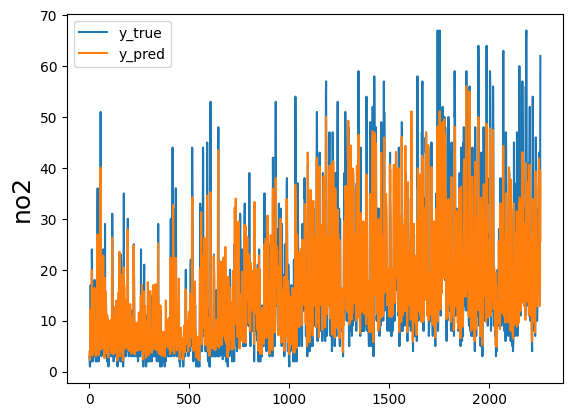

In [83]:
plt.plot(df_result['y_true'])
plt.plot(df_result['y_pred'])
plt.ylabel('no2',fontsize=18)
plt.legend(['y_true','y_pred'])
plt.show()

In [3]:
# PINTAMOS EL GRAFICO ANTERIOR DE VERDE
plt.plot(df_result['y_true'],color='green')
plt.plot(df_result['y_pred'])
plt.ylabel('no2',fontsize=18)
plt.legend(['y_true','y_pred'])
plt.show()


NameError: name 'df_result' is not defined

## Lag univariante 

In [87]:
no2_st=df_processed[df_processed.columns[mask]]
no2_st.head(10)

,no2,no2_lag1,no2_avg_window_length2,no2_lag2,no2_avg_window_length3,no2_lag3,no2_avg_window_length4
time_index,,,,,,,
2022-10-04 01:00:00,13.0,10.0,10.0,10.0,10.333333,11.0,11.25
2022-10-04 02:00:00,10.0,10.0,10.5,11.0,11.666667,14.0,15.00
2022-10-04 03:00:00,10.0,11.0,12.5,14.0,16.666667,25.0,22.75
2022-10-04 05:00:00,11.0,14.0,19.5,25.0,26.666667,41.0,23.00
2022-10-04 06:00:00,14.0,25.0,33.0,41.0,26.000000,12.0,26.25
2022-10-04 07:00:00,25.0,41.0,26.5,12.0,26.666667,27.0,35.50
2022-10-04 09:00:00,41.0,12.0,19.5,27.0,33.666667,62.0,39.25
2022-10-04 14:00:00,12.0,27.0,44.5,62.0,48.333333,56.0,41.75
2022-10-04 20:00:00,27.0,62.0,59.0,56.0,46.666667,22.0,38.75


Dimension train: (9025, 7)
Dimension test: (2257, 7)


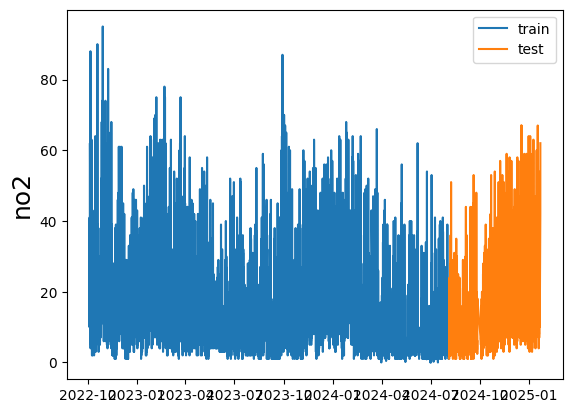

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [91]:
############################
# Train_test_split
###################

train_size=len(no2_st)*0.8
df_train=no2_st[:int(train_size)]
df_test=no2_st[int(train_size):]

print("Dimension train:", df_train.shape)
print("Dimension test:", df_test.shape)

#################3
# Grafico de la variable objetivo
##################

plt.plot(df_train.index,df_train[var_objetivo])
plt.plot(df_test.index,df_test[var_objetivo])
plt.ylabel(var_objetivo,fontsize=18)
plt.legend(['train','test'])
plt.show()

##################
# Pasamos a dataframe de H2O
##################

hf_train = h2o.H2OFrame(df_train, destination_frame="COCOR_LEPANTO_lagged_train_no2")
X=hf_train.columns #elegimos las variables independientes de nuestro modelo 
X.remove(var_objetivo)
hf_test = h2o.H2OFrame(df_test, destination_frame="COCOR_LEPANTO_lagged_test_no2")  

In [92]:
#######
# MODELACION
########

from h2o.automl import H2OAutoML

#Configuramos el modelo
aml = H2OAutoML(max_runtime_secs = 900,
                seed = 42,stopping_metric="RMSE",sort_metric="RMSE", keep_cross_validation_models=True,project_name="COCOR_LEPANTO_lagged_no2_SOLO",nfolds=-1)
#Lo entrenamos
aml.train(x = X, 
          y = var_objetivo,
          training_frame = hf_train,
          leaderboard_frame = hf_test)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),5/6
# GBM base models (used / total),1/1
# XGBoost base models (used / total),1/1
# DeepLearning base models (used / total),1/1
# GLM base models (used / total),0/1
# DRF base models (used / total),2/2
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5


In [96]:
##################
# Tabla de Modelos comparados
##################

lb2=aml.leaderboard
lb2

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
StackedEnsemble_BestOfFamily_4_AutoML_2_20250123_135218,8.23503,67.8157,5.58475,0.468101,67.8157
DeepLearning_grid_1_AutoML_2_20250123_135218_model_2,8.23667,67.8427,5.64759,0.473366,67.8427
DeepLearning_grid_3_AutoML_2_20250123_135218_model_1,8.25047,68.0703,5.69678,0.488047,68.0703
DeepLearning_1_AutoML_2_20250123_135218,8.26583,68.3239,5.53007,0.466309,68.3239
DeepLearning_grid_2_AutoML_2_20250123_135218_model_1,8.26998,68.3925,5.59931,nan,68.3925
StackedEnsemble_AllModels_2_AutoML_2_20250123_135218,8.27021,68.3964,5.55083,0.464611,68.3964
StackedEnsemble_BestOfFamily_3_AutoML_2_20250123_135218,8.27887,68.5396,5.55416,0.464285,68.5396
StackedEnsemble_AllModels_1_AutoML_2_20250123_135218,8.27962,68.5522,5.60124,0.471091,68.5522
StackedEnsemble_BestOfFamily_1_AutoML_2_20250123_135218,8.28417,68.6275,5.60614,0.471661,68.6275
StackedEnsemble_BestOfFamily_2_AutoML_2_20250123_135218,8.28824,68.6949,5.61323,0.471497,68.6949


In [97]:


print("\n=============================================================================\n")
##################
# Predicciones 
##################

#realizamos las predicciones
pred=aml.leader.predict(hf_test)


#Creamos una tabla comparativa y_true vs y_pred
df_result=pd.DataFrame()
df_result["y_true"]=df_test[var_objetivo].reset_index(drop=True)
df_result["y_pred"]=h2o.as_list(pred,use_pandas=True)
df_result.head()





stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/home/p3j0t4/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


,y_true,y_pred
0,3.0,3.518379
1,2.0,2.485950
2,1.0,2.355705
3,1.0,2.667340
4,2.0,6.520376


In [98]:

#Sacamos metricas
slope, intercept, r_value, p_value, std_err = stats.linregress(x=df_result['y_pred'],y=df_result['y_true'])
print('\n============================================\nR2 = ',r_value*r_value)



R2 =  0.5968012541045342


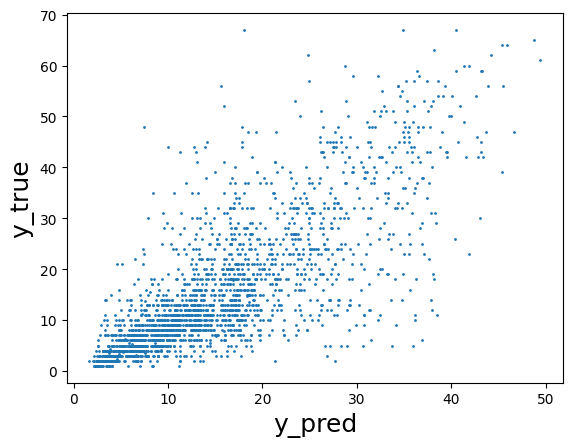

In [94]:
plt.scatter(x=df_result['y_pred'],y=df_result['y_true'],s=1)
plt.xlabel('y_pred',fontsize=18)
plt.ylabel('y_true',fontsize=18)
plt.show()

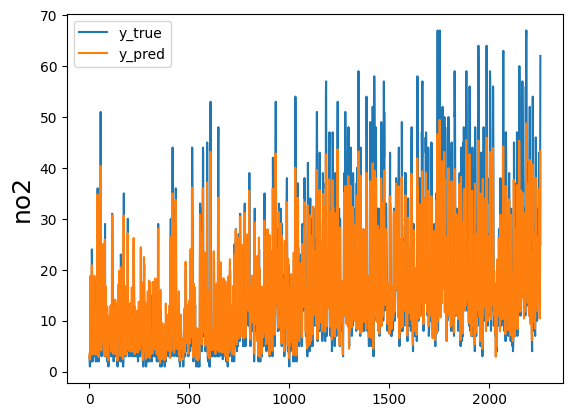

In [95]:
plt.plot(df_result['y_true'])
plt.plot(df_result['y_pred'])
plt.ylabel('no2',fontsize=18)
plt.legend(['y_true','y_pred'])
plt.show()